# Learning optimal K for LDA

In this notebook, we learn an optimal topic representation from the unit descriptions for each recorded sale. Specifically, we use the following approach:
- We split the training data into a subtraining/validation set (80/20 split).
- We vectorize each document in the subtraining set using a simple count vectorizer
- For each candidate number of topics K, we:
    - Learn an LDA model on the subtraining counts
    - Featurize the subtraining and validation sets using this model (i.e the documents feature representation are its topic weights).
    - Use gradient boosting to learn a regression model to predict log(price)
    - Evaluate this model's performance using MSE on the validation set

In [78]:
import pandas as pd
import numpy as np

In [99]:
#Read in all data
df = pd.read_csv('./../processed_data/sales_listings.1.csv', header=0, usecols=['saleid', 'price','description'])
for i in range(2,5):
    df = df.append(pd.read_csv('./../processed_data/sales_listings.{}.csv'.format(i), header=0, usecols=['saleid', 'price','description']))

In [100]:
print 'Shape with null descriptions', df.shape
df = df.dropna(axis=0, how='any')
print 'Shape without null vals', df.shape
df = df.loc[df['price'] > 1000, :]
print 'Shape without null vals or <1000 price', df.shape

Shape with null descriptions (372699, 3)
Shape without null vals (364099, 3)
Shape without null vals or <1000 price (364078, 3)


In [101]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=42)

In [102]:
Train_docs, Test_docs, Train_price, Test_price = train_test_split(train['description'], train['price'], test_size=0.2, random_state=42)

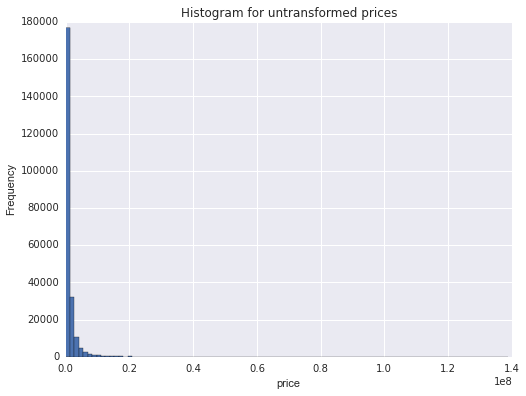

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.figure(figsize=(8,6))
plt.hist(Train_price.values, bins=100)
plt.title('Histogram for untransformed prices')
plt.xlabel('price')
plt.ylabel('Frequency')
plt.show()

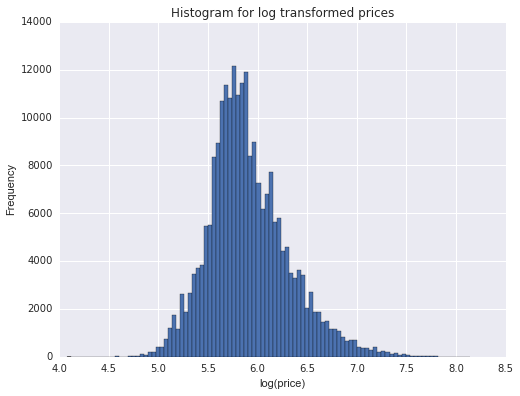

In [104]:
plt.figure(figsize=(8,6))
plt.hist(np.log10(Train_price.values), bins=100)
plt.title('Histogram for log transformed prices')
plt.xlabel('log(price)')
plt.ylabel('Frequency')

In [105]:
#Use this log transform
Train_price = np.log10(Train_price.values)
Test_price = np.log10(Test_price.values)

In [106]:
#Baseline model: just predict the average log price
baseline_pred = np.ones_like(Test_price)*np.mean(Train_price)
baseline_mse = mean_squared_error(Test_price, baseline_pred)

In [107]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

#Use GradientBoostingRegressor to learn function from thetas to price
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

#Note introduced hyperparameters: max_df, min_df
counter = CountVectorizer(stop_words='english', max_df = 0.9, min_df= 500)
train_counts = counter.fit_transform(Train_docs)

In [ ]:
models = {}
num_topics_to_test = range(5,35,5)
for n_topics in num_topics_to_test:
    print "Running K = {}\n".format(n_topics)
    print "\tLearning LDA model..."
    #Learn LDA model and get topic weights for training docs
    lda = LatentDirichletAllocation(n_topics=n_topics,
                                    max_iter=10,
                                    learning_method='online',
                                    n_jobs = -1, #Uses all cores,
                                    random_state=1234)
    topic_weights = lda.fit_transform(train_counts)
    
    #Learn GradientBoostedRegressor model of price ~ topic weights
    #Note this model was chosen since it is relatively immune to overfitting
    #and is non-linear (which is anticipated to improve performance)
    print "\tLearning GBR model..."
    gbr = GradientBoostingRegressor()
    gbr.fit(topic_weights, Train_price)
    
    print "\tGetting test-set score..."
    #Transform test_docs to topic weight matrix
    test_topics = lda.transform(counter.transform(Test_docs))
    test_pred = gbr.predict(test_topics)
    mse = mean_squared_error(Test_price, test_pred)
    
    #Save model and score:
    print "\tSaving model...\n"
    models[n_topics] = {'lda': lda, 'gbr': gbr, 'test_pred' : test_pred, 'mse': mse}

Running K = 5

	Learning LDA model...


In [ ]:
plt.figure(figsize=(8,6))
plt.hist(Test_price - baseline_pred, bins=100, label='Baseline: K = 0', alpha=0.5)
for model in models:
    #Replace gbr with models[model]['test_pred']
    plt.hist(Test_price - models[model]['gbr'].predict(test_topics),
             bins=100, label='K = {}'.format(model), alpha=0.5)
plt.legend()
plt.ylabel('Frequency')
plt.title('Comparing the distribution of residuals by K')
plt.xlabel('Residual (log(price) - predicted(log(price)))')
plt.show()
plt.savefig('residual_hist.png')

In [ ]:
plt.figure(figsize=(8,6))
mses = [(0, baseline_mse)] + [(x, models[x]['mse']) for x in models]
plt.plot([x[0] for x in mses], [x[1] for x in mses])
plt.xlabel('Number of topics K')
plt.ylabel('MSE for log(price) prediction')
plt.title('Learning curve: Optimizing K')
plt.savefig('learning_curve.png')

In [ ]:
#Use to visualize optimized model

#import pyLDAvis
#import pyLDAvis.sklearn
#pyLDAvis.enable_notebook()
#pyLDAvis.sklearn.prepare(lda, train_counts, counter)